In [1]:
# =============================================================
# DCRNN TRAINING PIPELINE (NO DRIVE — USE UPLOADED FILES)
# =============================================================

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================================================
# USER CONFIG
# =============================================================
SEQ_LEN  = 12
PRED_LEN = 2
BATCH_SIZE = 64
HIDDEN_DIM = 64
EPOCHS = 20
LR = 0.001
DROPOUT = 0.2

DATA_PATH = "/content/PEMS-BAY.csv"
ADJ_PATH  = "/content/PEMS-BAY-ADJ.h5"


Using device: cuda


In [3]:
# =============================
# CORRECT LOAD SPEED DATA
# =============================
speed_df = pd.read_csv(
    DATA_PATH,
    index_col=0,             # first column is timestamp
    parse_dates=True         # convert timestamp to datetime
)

print("Raw CSV shape:", speed_df.shape)
print("Index example:", speed_df.index[0])

# Convert to float32 numpy (52116 × 325)
data_all = speed_df.values.astype(np.float32)

T, N = data_all.shape
print("Total Timesteps:", T, "Sensors:", N)
""

Raw CSV shape: (52116, 325)
Index example: 2017-01-01 00:00:00
Total Timesteps: 52116 Sensors: 325


''

In [4]:
# =============================
# LOAD ADJ MATRIX
# =============================
with h5py.File(ADJ_PATH, "r") as f:
    adj = np.array(f["adjacency"])

adj = torch.FloatTensor(adj).to(device)
print("Adjacency shape:", adj.shape)


Adjacency shape: torch.Size([325, 325])


In [5]:
# =============================
# TIME SPLIT
# =============================
num_train = int(0.7 * T)
num_val   = int(0.2 * T)
num_test  = T - num_train - num_val

train_raw = data_all[:num_train]
val_raw   = data_all[num_train:num_train+num_val]
test_raw  = data_all[num_train+num_val:]

print("Train:", train_raw.shape)
print("Val:  ", val_raw.shape)
print("Test: ", test_raw.shape)


Train: (36481, 325)
Val:   (10423, 325)
Test:  (5212, 325)


In [6]:
# =============================
# NORMALIZATION
# =============================
train_mean = train_raw.mean(axis=0)
train_std  = train_raw.std(axis=0)

def normalize(x):
    return (x - train_mean) / (train_std + 1e-8)

train_norm = normalize(train_raw)
val_norm   = normalize(val_raw)
test_norm  = normalize(test_raw)


In [7]:
# =============================
# BUILD SEQUENCES
# =============================
def create_sequences(data, seq_len, pred_len):
    X, Y = [], []
    T = data.shape[0]

    for i in range(T - seq_len - pred_len):
        X.append(data[i:i+seq_len, :, None])
        Y.append(data[i+seq_len:i+seq_len+pred_len, :, None])

    return np.array(X), np.array(Y)

X_train, Y_train = create_sequences(train_norm, SEQ_LEN, PRED_LEN)
X_val,   Y_val   = create_sequences(val_norm,   SEQ_LEN, PRED_LEN)
X_test,  Y_test  = create_sequences(test_norm,  SEQ_LEN, PRED_LEN)

print("Train sequences:", X_train.shape, Y_train.shape)
print("Val sequences:  ", X_val.shape,   Y_val.shape)
print("Test sequences: ", X_test.shape,  Y_test.shape)


Train sequences: (36467, 12, 325, 1) (36467, 2, 325, 1)
Val sequences:   (10409, 12, 325, 1) (10409, 2, 325, 1)
Test sequences:  (5198, 12, 325, 1) (5198, 2, 325, 1)


In [8]:
# =============================
# DATA LOADERS
# =============================
train_loader = DataLoader(TensorDataset(
    torch.FloatTensor(X_train), torch.FloatTensor(Y_train)),
    batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(TensorDataset(
    torch.FloatTensor(X_val), torch.FloatTensor(Y_val)),
    batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(TensorDataset(
    torch.FloatTensor(X_test), torch.FloatTensor(Y_test)),
    batch_size=BATCH_SIZE, shuffle=False)


In [9]:
# =============================
# MODEL COMPONENTS
# =============================
class DiffusionConv(nn.Module):
    def __init__(self, num_nodes, F_in, F_out, dropout):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(F_in, F_out))
        nn.init.xavier_uniform_(self.theta)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj):
        diff = torch.einsum("ij,bjf->bif", adj, x)
        return self.dropout(torch.einsum("bif,fo->bio", diff, self.theta))


class DCRNNCell(nn.Module):
    def __init__(self, num_nodes, hidden_dim, dropout):
        super().__init__()
        self.diff = DiffusionConv(num_nodes, 1 + hidden_dim, hidden_dim, dropout)
        self.gru  = nn.GRUCell(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_t, h_prev, adj):
        combined = torch.cat([x_t, h_prev], dim=-1)
        conv = self.diff(combined, adj)

        B, N, H = conv.shape
        conv = conv.reshape(B*N, H)
        h_prev = h_prev.reshape(B*N, H)

        h = self.gru(conv, h_prev).reshape(B, N, H)
        return self.dropout(h)


In [10]:
class DCRNN(nn.Module):
    def __init__(self, num_nodes, hidden_dim, pred_len, adj, dropout):
        super().__init__()
        self.cell = DCRNNCell(num_nodes, hidden_dim, dropout)
        self.fc_out = nn.Linear(hidden_dim, pred_len)
        self.adj = adj

    def forward(self, x):
        B, T, N, _ = x.shape
        h = torch.zeros(B, N, HIDDEN_DIM, device=x.device)

        for t in range(T):
            h = self.cell(x[:, t], h, self.adj)

        out = self.fc_out(h)      # [B, N, 12]
        return out.permute(0, 2, 1).unsqueeze(-1)


🔥 New best model saved!
Epoch 1/20 | Train=0.422307 | Val=0.337465
🔥 New best model saved!
Epoch 2/20 | Train=0.257432 | Val=0.252425
🔥 New best model saved!
Epoch 3/20 | Train=0.209127 | Val=0.229822
🔥 New best model saved!
Epoch 4/20 | Train=0.196306 | Val=0.221782
🔥 New best model saved!
Epoch 5/20 | Train=0.189990 | Val=0.212298
🔥 New best model saved!
Epoch 6/20 | Train=0.185827 | Val=0.207885
🔥 New best model saved!
Epoch 7/20 | Train=0.182645 | Val=0.203726
🔥 New best model saved!
Epoch 8/20 | Train=0.180283 | Val=0.202432
🔥 New best model saved!
Epoch 9/20 | Train=0.179054 | Val=0.199229
🔥 New best model saved!
Epoch 10/20 | Train=0.177402 | Val=0.197398
🔥 New best model saved!
Epoch 11/20 | Train=0.176921 | Val=0.195951
Epoch 12/20 | Train=0.175554 | Val=0.196991
Epoch 13/20 | Train=0.174694 | Val=0.196556
🔥 New best model saved!
Epoch 14/20 | Train=0.173763 | Val=0.191539
Epoch 15/20 | Train=0.173586 | Val=0.193555
Epoch 16/20 | Train=0.172707 | Val=0.191730
Epoch 17/20 | Tra

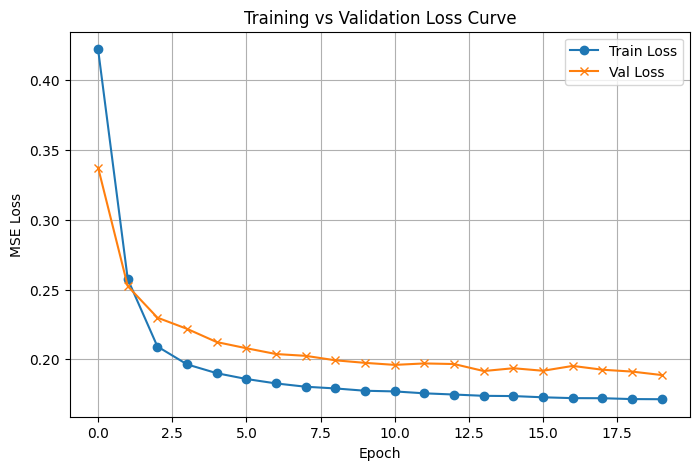

In [11]:
model = DCRNN(N, HIDDEN_DIM, PRED_LEN, adj, DROPOUT).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

best_val = float("inf")

# Lists to store epoch-level losses
train_curve = []
val_curve   = []

# =============================
# TRAINING
# =============================
for epoch in range(1, EPOCHS + 1):
    model.train()
    batch_train_losses = []

    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)

        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, Yb)
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

    # ---- Validation ----
    model.eval()
    batch_val_losses = []
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            preds = model(Xb)
            batch_val_losses.append(criterion(preds, Yb).item())

    # Compute mean losses for this epoch
    avg_train = np.mean(batch_train_losses)
    avg_val   = np.mean(batch_val_losses)

    train_curve.append(avg_train)
    val_curve.append(avg_val)

    # Save best model
    if avg_val < best_val:
        best_val = avg_val
        torch.save(model.state_dict(), "/content/dcrnn_best.pt")
        print("🔥 New best model saved!")

    print(f"Epoch {epoch}/{EPOCHS} | Train={avg_train:.6f} | Val={avg_val:.6f}")

print("Training complete! Best Val Loss:", best_val)

# =============================
# PLOT LOSS CURVE
# =============================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_curve, label="Train Loss", marker='o')
plt.plot(val_curve, label="Val Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss Curve")
plt.grid(True)
plt.legend()

plt.savefig("/content/loss_curve.png", dpi=200)
plt.show()
